<ipython-input-12-3a2fecece005>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dt'] = pd.to_datetime(data['dt'])


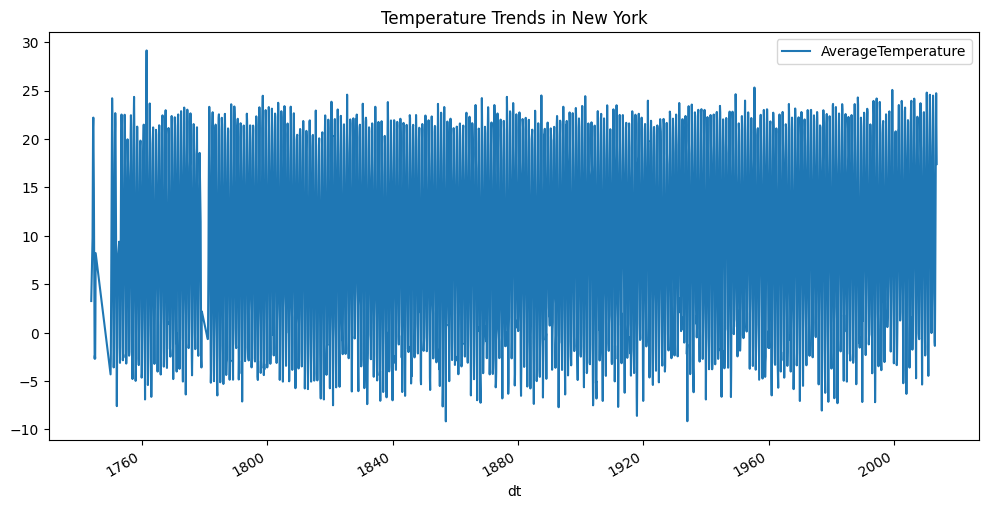

In [12]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Download latest version
path = kagglehub.dataset_download("berkeleyearth/climate-change-earth-surface-temperature-data")

# Load dataset
data = pd.read_csv(path +'/GlobalLandTemperaturesByCity.csv')
data = data[data['City'] == 'New York']
data['dt'] = pd.to_datetime(data['dt'])
data = data.set_index('dt')
data = data[['AverageTemperature']].dropna()

# Visualize data
data.plot(figsize=(12, 6))
plt.title("Temperature Trends in New York")
plt.show()

In [5]:
scaler = MinMaxScaler()
data['AverageTemperature'] = scaler.fit_transform(data[['AverageTemperature']])

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 12
X, y = create_sequences(data['AverageTemperature'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 2/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0026
Epoch 3/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 4/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0059 - val_loss: 0.0027
Epoch 5/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 6/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0062 - val_loss: 0.0038
Epoch 7/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0061 - val_loss: 0.0026
Epoch 8/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0057 - val_loss: 0.0028
Epoch 9/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0055 - val_loss: 0.0033
Epoch 10/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0056 - val_loss: 0.0023

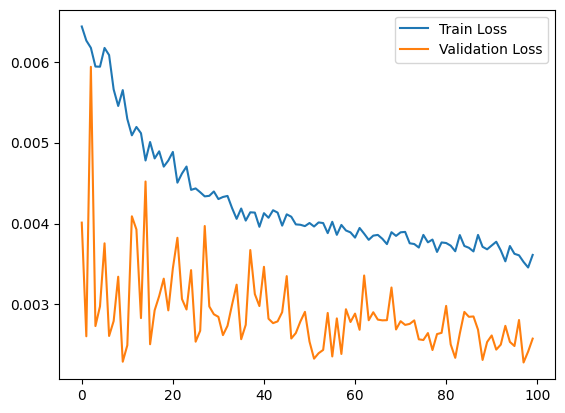

In [13]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

# Visualize training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


20/20 [==============================] - 1s 4ms/step


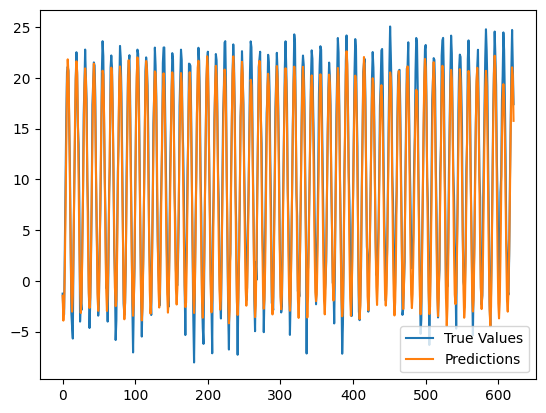

In [8]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()
